In [1]:
# import os
# print(os.getcwd())

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Check GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load Weather Time-Series Data
train_weather = pd.read_csv('/kaggle/input/dataset/train_timeseries.csv')
val_weather = pd.read_csv('/kaggle/input/dataset/validation_timeseries.csv')
test_weather = pd.read_csv('/kaggle/input/dataset/test_timeseries.csv')

# Load Soil Data
soil_data = pd.read_csv('/kaggle/input/dataset/soil_data.csv')

# Fill Missing Values
train_weather.interpolate(method='ffill', inplace=True)
val_weather.interpolate(method='ffill', inplace=True)
test_weather.interpolate(method='ffill', inplace=True)
soil_data.fillna(soil_data.mean(), inplace=True)

# Select Relevant Features
weather_features = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
                    'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
                    'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN']

soil_features = ['fips', 'lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6']

# Prepare Input Features
X_train_weather = train_weather[weather_features]
X_val_weather = val_weather[weather_features]
X_test_weather = test_weather[weather_features]
X_soil = soil_data[soil_features]

# Target Variable
y_train = train_weather['score']
y_val = val_weather['score']
y_test = test_weather['score']

# Normalize Features
weather_scaler = StandardScaler()
X_train_weather = weather_scaler.fit_transform(X_train_weather)
X_val_weather = weather_scaler.transform(X_val_weather)
X_test_weather = weather_scaler.transform(X_test_weather)

soil_scaler = StandardScaler()
X_soil = soil_scaler.fit_transform(X_soil)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_weather, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_weather, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_weather, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# y_train_tensor[torch.isnan(y_train_tensor)] = torch.nan_to_num(y_train_tensor, nan=torch.mean(y_train_tensor))
# y_val_tensor[torch.isnan(y_val_tensor)] = torch.nan_to_num(y_val_tensor, nan=torch.mean(y_val_tensor))
# y_test_tensor[torch.isnan(y_test_tensor)] = torch.nan_to_num(y_test_tensor, nan=torch.mean(y_test_tensor))

# y_train_tensor = torch.nan_to_num(y_train_tensor, nan=torch.mean(y_train_tensor))
# y_val_tensor = torch.nan_to_num(y_val_tensor, nan=torch.mean(y_val_tensor))
# y_test_tensor = torch.nan_to_num(y_test_tensor, nan=torch.mean(y_test_tensor))

# Replace NaNs in y_train_tensor with the mean of the non-NaN values
if torch.isnan(y_train_tensor).sum() > 0:
    mean_value = torch.mean(y_train_tensor[~torch.isnan(y_train_tensor)])
    y_train_tensor[torch.isnan(y_train_tensor)] = mean_value

# Replace NaNs in y_val_tensor
if torch.isnan(y_val_tensor).sum() > 0:
    mean_value = torch.mean(y_val_tensor[~torch.isnan(y_val_tensor)])
    y_val_tensor[torch.isnan(y_val_tensor)] = mean_value

# Replace NaNs in y_test_tensor
if torch.isnan(y_test_tensor).sum() > 0:
    mean_value = torch.mean(y_test_tensor[~torch.isnan(y_test_tensor)])
    y_test_tensor[torch.isnan(y_test_tensor)] = mean_value


# Create Datasets & DataLoaders
batch_size = 320
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("NaN in y_train after fix:", torch.isnan(y_train_tensor).sum().item())
print("NaN in y_val after fix:", torch.isnan(y_val_tensor).sum().item())
print("NaN in y_test after fix:", torch.isnan(y_test_tensor).sum().item())

# X_train_tensor[torch.isnan(X_train_tensor)] = 0  # Replace NaNs with 0
# y_train_tensor[torch.isnan(y_train_tensor)] = 0
# y_val_tensor[torch.isnan(y_val_tensor)] = 0
# y_test_tensor[torch.isnan(y_val_tensor)] = 0

Using device: cuda


/tmp/ipykernel_19/2326833688.py:21: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_weather.interpolate(method='ffill', inplace=True)
/tmp/ipykernel_19/2326833688.py:22: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val_weather.interpolate(method='ffill', inplace=True)
/tmp/ipykernel_19/2326833688.py:23: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_weather.interpolate(method='ffill', inplace=True)


NaN in y_train after fix: 0
NaN in y_val after fix: 0
NaN in y_test after fix: 0


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class DroughtCNN(nn.Module):
    def __init__(self, input_size):
        super(DroughtCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Compute the correct flattened size dynamically
        dummy_input = torch.randn(1, 1, input_size)  # Simulate a single sample
        out = self.pool(F.relu(self.conv1(dummy_input)))
        out = self.pool(F.relu(self.conv2(out)))
        self.flattened_size = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)  # Regression output

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
class DroughtLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(DroughtLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Regression output

    def forward(self, x):
        x, _ = self.lstm(x.unsqueeze(1))  # LSTM expects 3D input (batch, seq, features)
        x = self.fc(x[:, -1, :])  # Take last LSTM output
        return x


In [5]:
class DroughtCNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(DroughtCNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(32 * (input_size // 2), hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Regression output

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 1, -1)  # Prepare for LSTM
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x


In [6]:
import logging
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from collections import Counter
from PIL import Image

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate decay
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Print progress every 50 batches
            if batch_idx % 1000 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}')
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                
                # For regression task, store predictions and labels
                predicted = outputs.view(-1)
                labels = y_val.view(-1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Calculate metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        # Calculate MSE as accuracy measure for regression
        val_accuracy = np.mean((all_preds - all_labels) ** 2)
        val_accuracies.append(val_accuracy)
        
        # For multiclass classification (0-5 ranges)
        # Convert to integer classes for F1 score
        pred_classes = np.clip(all_preds, 0, 5).round().astype(int)
        label_classes = all_labels.round().astype(int)
        val_f1 = f1_score(label_classes, pred_classes, average="weighted", zero_division=1)
        val_f1_scores.append(val_f1)
        
        # Update learning rate
        scheduler.step()
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MSE: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")
        
    return train_losses, val_losses, val_accuracies, val_f1_scores


# Choose Model and Train
model = DroughtCNN(input_size=X_train_tensor.shape[1])
# Using a higher learning rate and fewer epochs
train_losses, val_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, lr=0.01, epochs=20)

Epoch: 1/20 | Batch: 0/60315 | Loss: 2.1228
Epoch: 1/20 | Batch: 1000/60315 | Loss: 1.3390
Epoch: 1/20 | Batch: 2000/60315 | Loss: 0.9366
Epoch: 1/20 | Batch: 3000/60315 | Loss: 1.1906
Epoch: 1/20 | Batch: 4000/60315 | Loss: 1.3524
Epoch: 1/20 | Batch: 5000/60315 | Loss: 1.1753
Epoch: 1/20 | Batch: 6000/60315 | Loss: 0.9696
Epoch: 1/20 | Batch: 7000/60315 | Loss: 1.1204
Epoch: 1/20 | Batch: 8000/60315 | Loss: 1.5082
Epoch: 1/20 | Batch: 9000/60315 | Loss: 1.1109
Epoch: 1/20 | Batch: 10000/60315 | Loss: 1.3734
Epoch: 1/20 | Batch: 11000/60315 | Loss: 1.1696
Epoch: 1/20 | Batch: 12000/60315 | Loss: 1.1828
Epoch: 1/20 | Batch: 13000/60315 | Loss: 1.2859
Epoch: 1/20 | Batch: 14000/60315 | Loss: 1.4570
Epoch: 1/20 | Batch: 15000/60315 | Loss: 1.1575
Epoch: 1/20 | Batch: 16000/60315 | Loss: 1.0999
Epoch: 1/20 | Batch: 17000/60315 | Loss: 1.2303
Epoch: 1/20 | Batch: 18000/60315 | Loss: 1.4313
Epoch: 1/20 | Batch: 19000/60315 | Loss: 1.3035
Epoch: 1/20 | Batch: 20000/60315 | Loss: 1.4038
Epoch

Test Accuracy: 0.8320, Test F1: 0.4810


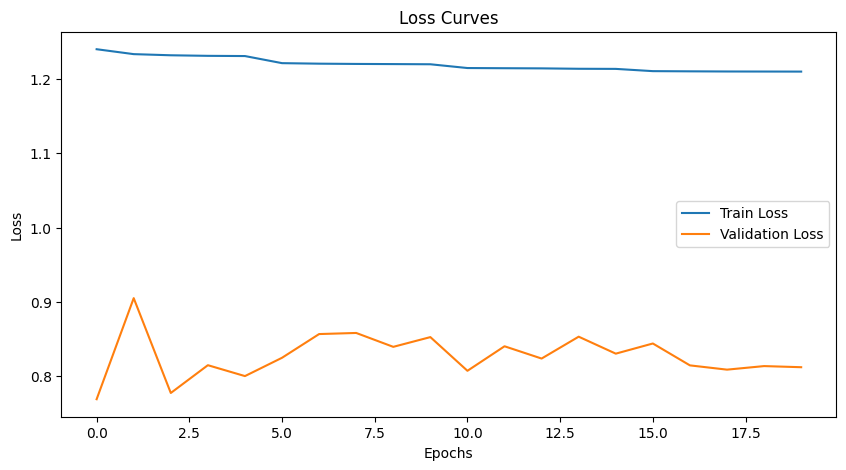

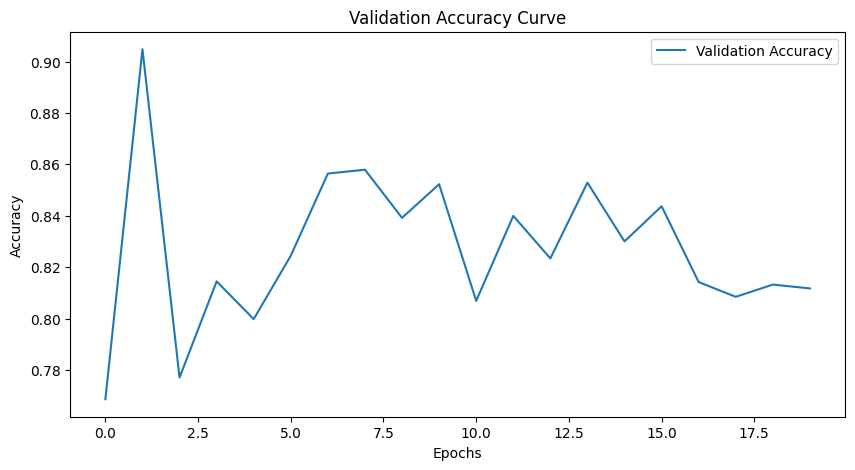

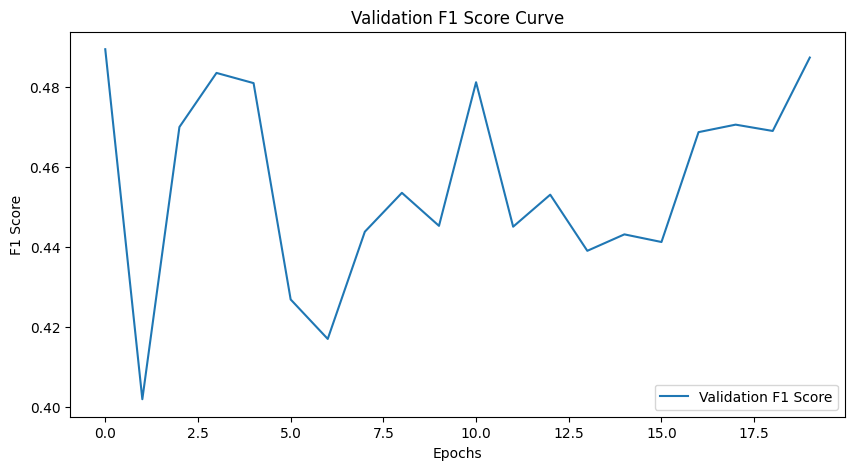

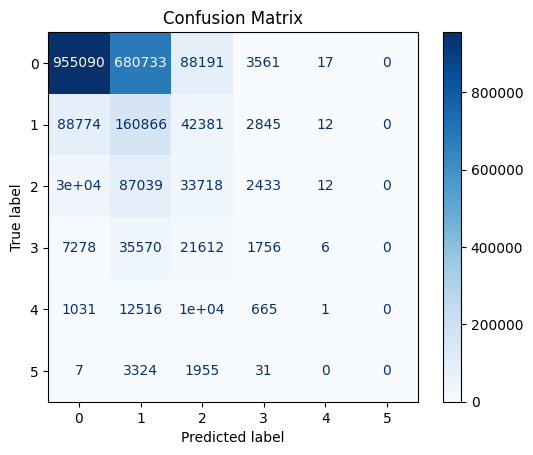

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.55      0.68   1727592
           1       0.16      0.55      0.25    294878
           2       0.17      0.22      0.19    153525
           3       0.16      0.03      0.05     66222
           4       0.02      0.00      0.00     24414
           5       1.00      0.00      0.00      5317

    accuracy                           0.51   2271948
   macro avg       0.40      0.22      0.19   2271948
weighted avg       0.71      0.51      0.56   2271948



In [7]:
# Visualise on test set
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def evaluate_model(model, test_loader):
    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            labels = y_test.view(-1)
            predicted = outputs.view(-1)
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_preds = np.array(test_preds)
    test_labels = np.array(test_labels).round(0).astype(np.int16)
    test_preds = np.clip(test_preds, 0, 5) # Ensure predictions are within the range [0, 5]
    test_preds = np.round(test_preds, 0).astype(np.int16)  # Convert to binary
    test_accuracy = np.mean((test_preds - test_labels) ** 2)
    test_f1 = f1_score((test_labels > 0.5).astype(int), (test_preds > 0.5).astype(int), average="binary", zero_division=1)

    return test_accuracy, test_f1, test_labels, test_preds

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

def plot_accuracy(val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.legend()
    plt.show()

def plot_f1(val_f1_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score Curve')
    plt.legend()
    plt.show()

def plot_confusion_matrix(test_labels, test_preds):
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def plot_classification_report(test_labels, test_preds):
    report = classification_report(test_labels, test_preds, zero_division=1)
    print("Classification Report:")
    print(report)

# Provide metrics
test_accuracy, test_f1, test_labels, test_preds = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")
plot_loss(train_losses, val_losses)
plot_accuracy(val_accuracies)
plot_f1(val_f1_scores)
plot_confusion_matrix(test_labels, test_preds)
plot_classification_report(test_labels, test_preds)
# Save the model
torch.save(model.state_dict(), 'drought_model.pth')
